In [1]:
'''
Defining idealized pinger and hydrophone
- signal is assumed spherical monopole unattenuated with distance
'''

import numpy as np

c = 3 # m/s speed of sound in water 
t_final = 5
dt = 0.005
n = int(t_final/dt)
t_arr = np.linspace(0, t_final, n+1)

A = 10    
phi = 0                 # rad
f = 0.5                 # hz
w = 2*np.pi*f
t2 = 2 #s

def signal(t):
    if t < 0 or t > t2:
        return 0
    return A*np.sin(w*t - phi)

class Pinger:
    def __init__(self, x, y, z=0):
        self.pos = np.array([x, y, z])
        self.signal = np.frompyfunc(signal, 1, 1)   

class Hydrophone:
    def __init__(self, x, y, z=0):
        self.pos = self.pos_est = np.array([x, y, z])
        self.th = None # discrete time history (pressure vs. time)
    
    def set_th(self, pinger):
        r = self.pos - pinger.pos
        t_delay = np.linalg.norm(r)/c  # time delay of signal        
        self.th = pinger.signal(t_arr-t_delay)

In [2]:
'''
Suppose three hydrophones are arranged in a square array, 
the time history of the pinger signal is known
'''

h1 = Hydrophone(0, 0)
h2 = Hydrophone(1, 0)
h3 = Hydrophone(0, 1)
hydrophones = [h1, h2, h3]
pinger = Pinger(3, 5)

for h in hydrophones:
    h.set_th(pinger)

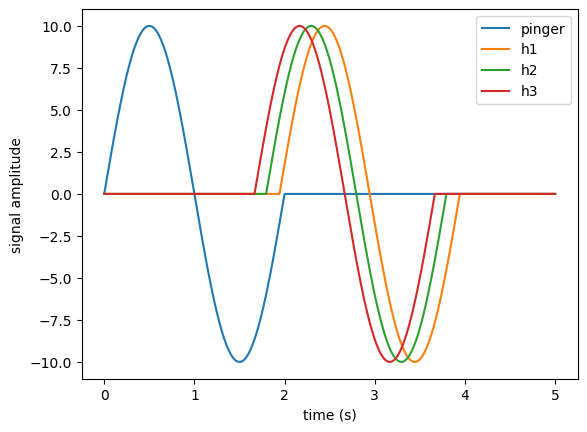

In [3]:
'''
Plotting the time history of the signal as transmitted by the pinger
and detected by the hydrophones
'''

import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.plot(t_arr, pinger.signal(t_arr), label='pinger')
ax1.plot(t_arr, h1.th, label='h1')
ax1.plot(t_arr, h2.th, label='h2')
ax1.plot(t_arr, h3.th, label='h3')
ax1.set_xlabel("time (s)")
ax1.set_ylabel("signal amplitude")
ax1.legend()
plt.show()


In [4]:
'''
This generates a 2D matrix grid of the pressure at each discrete point
due to the pinger signal
'''

def signal_grid(pinger, X, Y, t=0):
    r = np.sqrt((X-pinger.pos[0])**2 + (Y-pinger.pos[1])**2)
    t_delay = r/c 
    return pinger.signal(t-t_delay)

def plot_points(ax, hydrophones, pinger):
    for h in hydrophones:
        ax.scatter(h.pos[0], h.pos[1], marker="o", color='black')
    ax.scatter(pinger.pos[0], pinger.pos[1], marker="o", color='purple')

X,Y = np.meshgrid(np.linspace(-2,6,400),np.linspace(-2,6,400))
P = signal_grid(pinger, X=X, Y=Y)

<IPython.core.display.Javascript object>


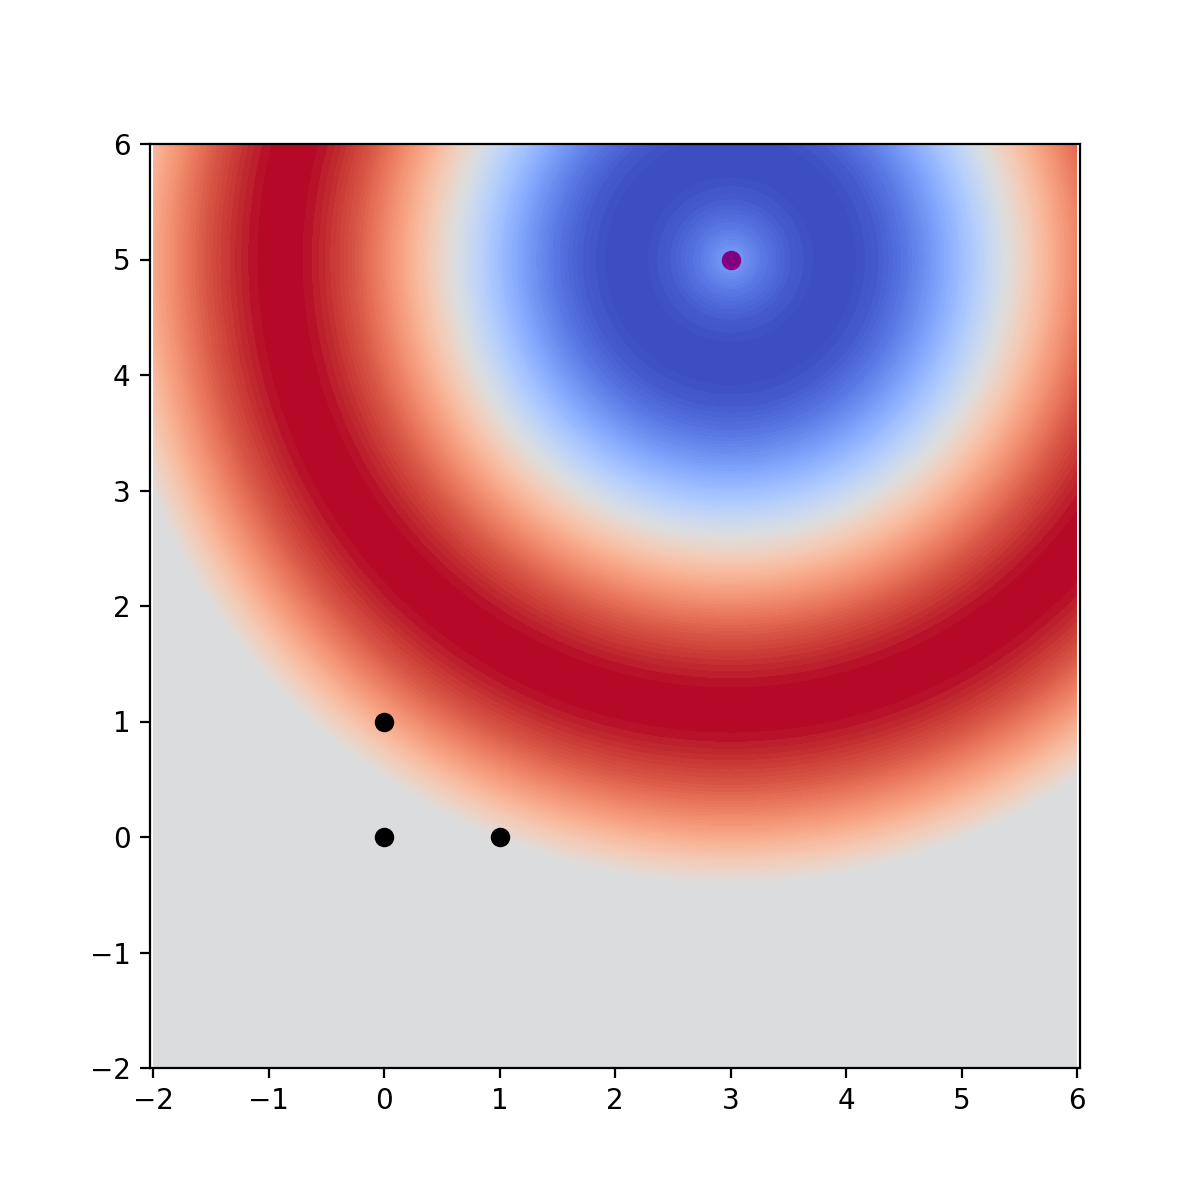

In [5]:
'''
Assuming the signal is 2D - animating propagation
'''

%matplotlib notebook

import matplotlib.animation as animation

fig2, ax2 = plt.subplots(figsize=(6,6))
ax2.axis('equal')
cf = plt.contourf(X, Y, P, cmap='coolwarm', levels=100)    # first image on screen

hydrophones=[h1, h2, h3]

# animation function
def animate(frame_num):
    global cf
    global ax2
    global hydrophones
    global pinger
    
    t=frame_num/30
    P_t = signal_grid(pinger, X=X, Y=Y, t=t)
    for c in cf.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cf = plt.contourf(X, Y, P_t, cmap='coolwarm', levels=100)
    plot_points(ax2, hydrophones, pinger)
    return cf

anim = animation.FuncAnimation(fig2, animate, frames=120, repeat=False)
#anim.save('animation.mp4', writer=animation.FFMpegWriter())

fig2.show()

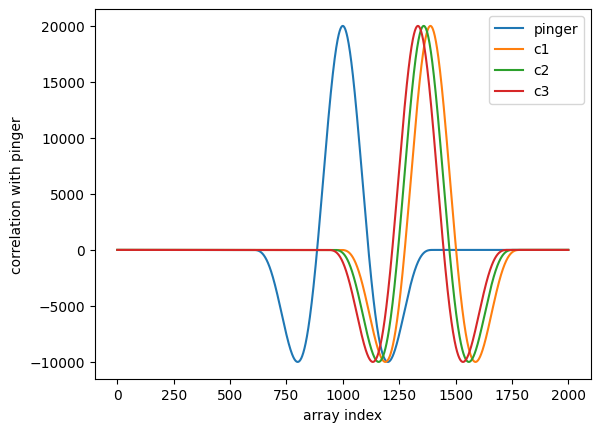

In [6]:
'''
Cross correlation between pinger and hydrophones
'''

%matplotlib inline

p_th = pinger.signal(t_arr)
c_ping = np.correlate(p_th, p_th, 'full')
c_1 = np.correlate(h1.th, p_th, 'full')
c_2 = np.correlate(h2.th, p_th, 'full')
c_3 = np.correlate(h3.th, p_th, 'full')

fig3, ax3 = plt.subplots()
ax3.plot(c_ping, label='pinger')
ax3.plot(c_1, label='c1')
ax3.plot(c_2, label='c2')
ax3.plot(c_3, label='c3')
ax3.set_xlabel("array index")
ax3.set_ylabel("correlation with pinger")
ax3.legend()

plt.close(fig2)
plt.show()

In [7]:
'''
Comparing the time delay calculated via cross-correlation
with that calculated by t = r/c
'''

i_ping = np.argmax(c_ping)
dt_h1 = (np.argmax(c_1)-i_ping)*dt
dt_h2 = (np.argmax(c_2)-i_ping)*dt
dt_h3 = (np.argmax(c_3)-i_ping)*dt

print("cross correlation results:")
print("h1 time delay: ", dt_h1, "s")
print("h2 time delay: ", dt_h2, "s")
print("h3 time delay: ", dt_h3, "s")

r = h1.pos - pinger.pos
dt_h1 = np.linalg.norm(r)/c

r = h2.pos - pinger.pos
dt_h2 = np.linalg.norm(r)/c

r = h3.pos - pinger.pos
dt_h3 = np.linalg.norm(r)/c

print("distance-velocity results:")
print("h1 time delay: ", dt_h1, "s")
print("h2 time delay: ", dt_h2, "s")
print("h3 time delay: ", dt_h3, "s")

cross correlation results:
h1 time delay:  1.945 s
h2 time delay:  1.795 s
h3 time delay:  1.665 s
distance-velocity results:
h1 time delay:  1.9436506316151003 s
h2 time delay:  1.7950549357115013 s
h3 time delay:  1.6666666666666667 s


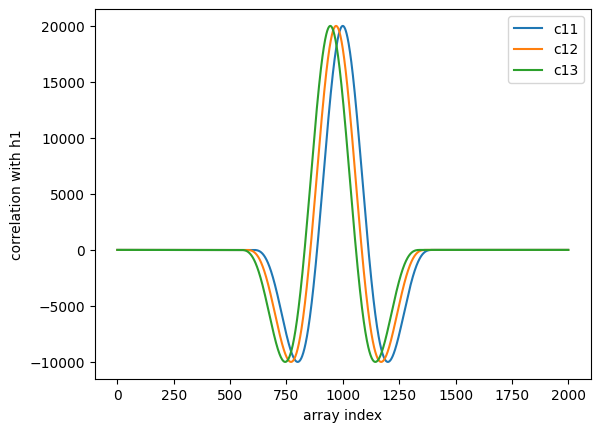

In [8]:
'''
Using cross correlation to find time delay between h1 and h2/h3
'''

c_11 = np.correlate(h1.th, h1.th, 'full')
c_12 = np.correlate(h2.th, h1.th, 'full')
c_13 = np.correlate(h3.th, h1.th, 'full')

fig4, ax4 = plt.subplots()
ax4.plot(c_11, label='c11')
ax4.plot(c_12, label='c12')
ax4.plot(c_13, label='c13')
ax4.set_xlabel("array index")
ax4.set_ylabel("correlation with h1")
ax4.legend()
plt.show()

In [9]:
i_h1 = np.argmax(c_11)
dt_12 = (np.argmax(c_12)-i_h1)*dt
dt_13 = (np.argmax(c_13)-i_h1)*dt

print("cross correlation results:")
print("h2-h1 time delay (dt_12): ", dt_12, "s")
print("h3-h1 time delay (dt_13): ", dt_13, "s")

cross correlation results:
h2-h1 time delay (dt_12):  -0.15 s
h3-h1 time delay (dt_13):  -0.275 s


In [10]:
'''
Generalized functions for preforming cross correlation and time delay
calculations from hydrophones

'''

'''
returns list - cross-correlations [c_11, c_12, c_13] relative to <ref>
<ref> is taken as the first hydrophone in the list

hydrophones - <list/tuple>: [h1, h2, h3]
'''
def xcorr(hydrophones):
    correlations = []
    ref = hydrophones[0]
    for h in hydrophones:
        correlations.append(np.correlate(h.th, ref.th, 'full'))
    return correlations
    
'''
returns list - signal delays (seconds) relative to <ref> hydrophone
<ref> is taken as the first hydrophone in the list

correlations - <list/tuple>: [c_11, c_12, c_13]
'''
def get_delays_from_xcorr(corr):
    global dt
    delays = []
    i_ref = np.argmax(corr[0])
    for c in corr:
        delays.append((np.argmax(c)-i_ref)*dt)
    return delays
    
    
'''
returns list - signal delays (seconds) relative to <ref> hydrophone
<ref> is taken as the first hydrophone in the list (delays relative 
to this hydrophone's readings)

hydrophones - <list/tuple>: [h1, h2, h3]
'''
def get_delays(hydrophones):
    corr = xcorr(hydrophones)
    return get_delays_from_xcorr(corr)

In [11]:
'''
returns the unit bearing vector, 
- assuming the wave is planar

#TODO - assumes configuration of 3 hydrophones at right angles
delays - <list/tuple>:      [dt_11, dt_12, dt_13] 
hydrophones - <list/tuple>: [h1, h2, h3]
'''
def estimate_bearing_planar(delays, hydrophones):
    global c
    
    dt_11, dt_12, dt_13 = delays
    h1, h2, h3 = hydrophones
    
    # TODO - in general find pair of hydrophones with
    # largest dx, dy
    dx = np.linalg.norm(h2.pos_est[0] - h1.pos_est[0])
    dy = np.linalg.norm(h3.pos_est[1] - h1.pos_est[1])
    
    # velocity of planar wave: u = u_x*i + u_y*j + u_z*k
    u_x = dt_12/dx#dx/dt_12
    u_y = dt_13/dy#dy/dt_13

    # negative if planar assumption leads to large errors
    u_z_sqr = c**2 - u_x**2 - u_y**2
    u_z = 0#np.sqrt(u_z_sqr) if u_z_sqr > 0 else 0
    u = np.array([u_x, u_y, u_z])

    # bearing to pinger is in opposite direction of wave propagation
    return -u/np.linalg.norm(u)

actual bearing:  [0.51449576 0.85749293 0.        ]
estimated bearing:  [ 0.47885213  0.87789557 -0.        ]
angle error: 2.35329687 degrees


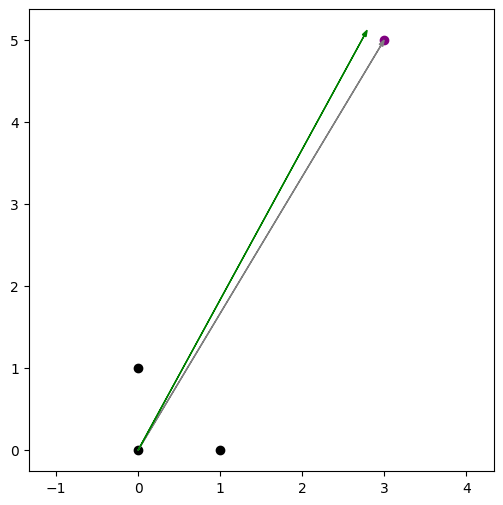

In [12]:
'''
Plotting estimated pinger bearing based on planar wave assumption

- assumes that hydrophones are arranged in array at right angles
'''

def actual_bearing(h1, pinger, norm=True):
    bearing = pinger.pos - h1.pos
    if norm:
        bearing = bearing/np.linalg.norm(bearing)
    return bearing
    
def error_angle(bearing, bearing_est):
    dot = np.dot(bearing, bearing_est)
    if dot < -1 or dot > 1:
        return 0
    angle_err = round(np.arccos(dot)*180/np.pi, 8)
    return angle_err


delays = get_delays(hydrophones)
bearing = actual_bearing(h1, pinger)
bearing_est = estimate_bearing_planar(delays, hydrophones)
angle_err = error_angle(bearing, bearing_est)

print("actual bearing: ", bearing)
print("estimated bearing: ", bearing_est)
print("angle error:", angle_err, "degrees")

def plot_bearing(hydrophones, pinger, bearing_est):
    fig, ax = plt.subplots(figsize=(6,6))
    plot_points(ax, hydrophones, pinger)
    
    # take first hydrophone as reference
    h1 = hydrophones[0]

    # plot actual bearing
    bearing = actual_bearing(h1, pinger, norm=False)
    k = np.linalg.norm(bearing)
    plt.arrow(h1.pos[0], h1.pos[1], 
          bearing[0], bearing[1], 
          head_width=0.05, length_includes_head=True, color='grey')


    # plot estimated bearing
    bearing_est_scaled=bearing_est*k
    plt.arrow(h1.pos[0], h1.pos[1], 
          bearing_est_scaled[0], bearing_est_scaled[1], 
          head_width=0.05, length_includes_head=True, color='green')

    ax.axis('equal')
    plt.show()
    
plot_bearing(hydrophones, pinger, bearing_est)

In [13]:
'''
Suppose there are errors in the signal readings and 
imprecise knowledge of hydrophone position. 

- assume error in signal reading is Gaussian 
- error in measurement is uniform distribution within uncertainty
'''

from numpy.random import normal as randN
from numpy.random import uniform as randU

class ImperfectHydrophone(Hydrophone):
    '''
    sigma - standard deviation of error in signal readings
    unc - uncertainty of position measurement of hydrophone (positive)
    '''
    def __init__(self, x, y, z=0, sigma=0.2, unc=0.1):
        super().__init__(randU(x-unc, x+unc), 
                         randU(y-unc, y+unc), 
                         randU(z-unc, z+unc))
        self.pos_est = np.array([x,y,z])
        self.sigma = sigma
        self.randN_ufunc = np.frompyfunc(randN, 2, 1) 
  
    
    def set_th(self, pinger):       
        super().set_th(pinger)
        self.th = self.randN_ufunc(self.th, self.sigma)


h1 ideal: [0 0 0] actual: [-0.06764325  0.07051673  0.09967664]
h2 ideal: [1 0 0] actual: [ 1.04505431 -0.01724999  0.02777367]
h3 ideal: [0 1 0] actual: [ 0.06130975  0.91602124 -0.01362613]


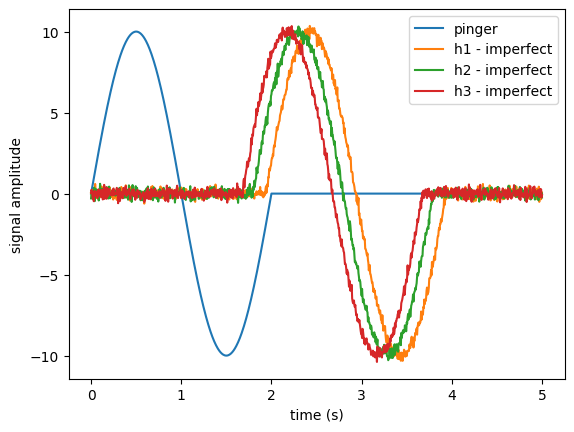

In [14]:
h1_imp = ImperfectHydrophone(h1.pos[0], h1.pos[1], h1.pos[2])
h2_imp = ImperfectHydrophone(h2.pos[0], h2.pos[1], h2.pos[2])
h3_imp = ImperfectHydrophone(h3.pos[0], h3.pos[1], h3.pos[2])
print("h1 ideal:", h1_imp.pos_est, "actual:", h1_imp.pos)
print("h2 ideal:", h2_imp.pos_est, "actual:", h2_imp.pos)
print("h3 ideal:", h3_imp.pos_est, "actual:", h3_imp.pos)

h1_imp.set_th(pinger)
h2_imp.set_th(pinger)
h3_imp.set_th(pinger)
hydrophones_imp = [h1_imp, h2_imp, h3_imp]

fig6, ax6 = plt.subplots()
ax6.plot(t_arr, pinger.signal(t_arr), label='pinger')
ax6.plot(t_arr, h1_imp.th, label='h1 - imperfect')
ax6.plot(t_arr, h2_imp.th, label='h2 - imperfect')
ax6.plot(t_arr, h3_imp.th, label='h3 - imperfect')
ax6.set_xlabel("time (s)")
ax6.set_ylabel("signal amplitude")
ax6.legend()
plt.show()

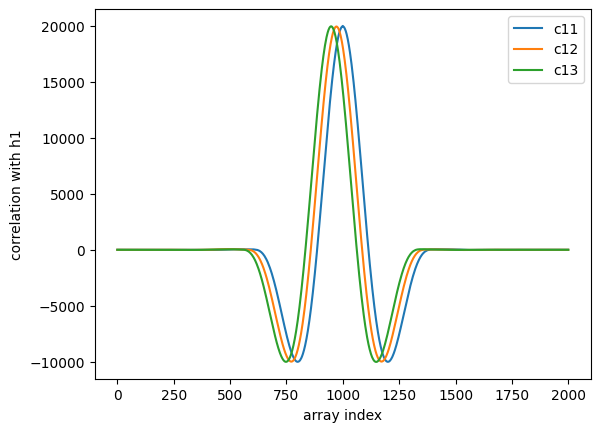

In [15]:
'''
Cross-correlation to find time delay between h1 and h2/h3 
with imperfections
'''

c_11,c_12,c_13 = xcorr(hydrophones_imp)

fig7, ax7 = plt.subplots()
ax7.plot(c_11, label='c11')
ax7.plot(c_12, label='c12')
ax7.plot(c_13, label='c13')
ax7.set_xlabel("array index")
ax7.set_ylabel("correlation with h1")
ax7.legend()
plt.show()

In [16]:
dt_11,dt_12,dt_13 = delays_imp = get_delays(hydrophones_imp)

print("cross correlation results:")
print("h2-h1 time delay (dt_12): ", dt_12, "s")
print("h3-h1 time delay (dt_13): ", dt_13, "s")

cross correlation results:
h2-h1 time delay (dt_12):  -0.14 s
h3-h1 time delay (dt_13):  -0.255 s


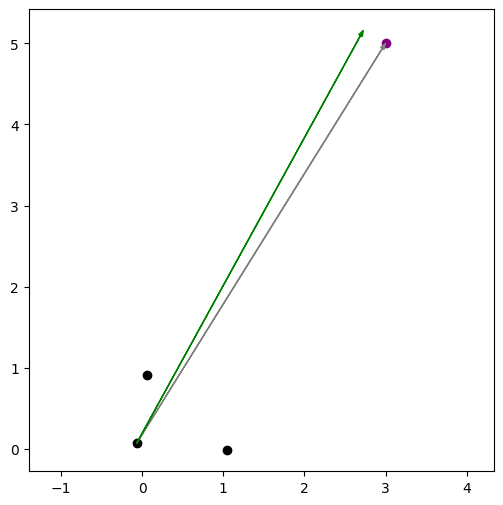

actual bearing:  [ 0.52827485  0.8488999  -0.01716518]
estimated bearing:  [ 0.48125881  0.87657855 -0.        ]
angle error: 3.27747459 degrees


In [17]:
'''
Estimated pinger bearing with imperfections, 
using planar 2D wave assumption
'''

bearing = actual_bearing(h1_imp, pinger)
bearing_est = estimate_bearing_planar(delays_imp, hydrophones_imp)
angle_err = error_angle(bearing, bearing_est)

plot_bearing(hydrophones_imp, pinger, bearing_est)

print("actual bearing: ", bearing)
print("estimated bearing: ", bearing_est)
print("angle error:", angle_err, "degrees")

p1: [3.54746402 5.93232988 1.08764022]
p2: [ 3.54746402  5.93232988 -1.08764022]
actual bearing:  [0.51449576 0.85749293 0.        ]
estimated bearing:  [ 0.50698755  0.84782182 -0.15544063]
angle error: 8.94275141 degrees


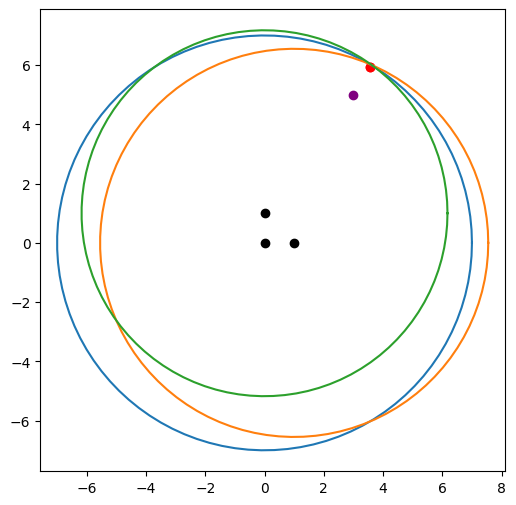

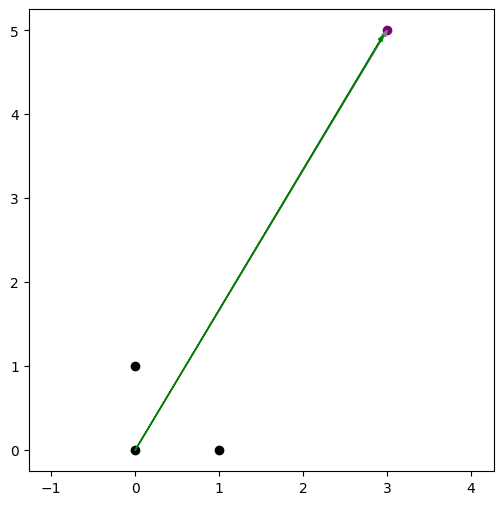

In [18]:
'''
Estimate bearing using trilateration 
- if r1 is assumed to be known the pinger can be triangulated
- r2 = r1 + dt_12*c, r3 = r1 + dt_13*c
- finding intersection of 3 spheres radius r1, r2, r3
- scan over possible r1 to find bearing
- *note: [r1, r2, r3] is ordered same as [dt_11, dt_12, dt_13]
ie. it is not possible to have r1 < r2 if dt_11 > dt_12 
since dt_11 > dt_12 => (0 > positive)
'''

'''
this function was taken from 
https://stackoverflow.com/questions/1406375/finding-intersection-points-between-3-spheres
'''
# Find the intersection of three spheres                 
# P1,P2,P3 are the centers, r1,r2,r3 are the radii       
# Implementaton based on Wikipedia Trilateration article.                              
def trilaterate(P1,P2,P3,r1,r2,r3):                      
    temp1 = P2-P1                                        
    e_x = temp1/np.linalg.norm(temp1)                              
    temp2 = P3-P1                                        
    i = np.dot(e_x,temp2)                                   
    temp3 = temp2 - i*e_x                                
    e_y = temp3/np.linalg.norm(temp3)                              
    e_z = np.cross(e_x,e_y)                                 
    d = np.linalg.norm(P2-P1)                                      
    j = np.dot(e_y,temp2)                                   
    x = (r1*r1 - r2*r2 + d*d) / (2*d)                    
    y = (r1*r1 - r3*r3 -2*i*x + i*i + j*j) / (2*j)       
    temp4 = r1*r1 - x*x - y*y                            
    if temp4<0:                                          
        raise Exception("The three spheres do not intersect!");
    z = np.sqrt(temp4)                                      
    p_12_a = P1 + x*e_x + y*e_y + z*e_z                  
    p_12_b = P1 + x*e_x + y*e_y - z*e_z                  
    return p_12_a,p_12_b 


    
def plot_circle(x_c, y_c, r):
    theta = np.linspace(0, 2*np.pi, 100)
    x = r*np.cos(theta)+x_c
    y = r*np.sin(theta)+y_c
    plt.plot(x,y)
    
h1, h2, h3 = hydrophones
dt_11, dt_12, dt_13 = delays
    

#dt_min = np.min(delays)
#r1_min = c*dt_min if dt_min < 0 else 0

r1 = np.sqrt(3**2 + 5**2)*1.2
r2 = r1 + dt_12*c
r3 = r1 + dt_13*c
        
p1, p2 = trilaterate(
            h1.pos_est, h2.pos_est, h3.pos_est, 
            r1, r2, r3)

print("p1:", p1)
print("p2:", p2)

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')

plot_points(ax, hydrophones, pinger)
plot_circle(h1.pos[0], h1.pos[1], r1)
plot_circle(h2.pos[0], h2.pos[1], r2)
plot_circle(h3.pos[0], h3.pos[1], r3)

ax.scatter(p1[0], p1[1], marker="o", color='red')
ax.scatter(p2[0], p2[1], marker="o", color='red')


bearing_est_1 = p1/np.linalg.norm(p1)
bearing_est_2 = p2/np.linalg.norm(p2)

bearing = actual_bearing(h1, pinger)
bearing_est_1 = p1/np.linalg.norm(p1)
bearing_est_2 = p2/np.linalg.norm(p2)
angle_err = error_angle(bearing, bearing_est_2)

print("actual bearing: ", bearing)
print("estimated bearing: ", bearing_est_2)
print("angle error:", angle_err, "degrees")

plot_bearing(hydrophones, pinger, bearing_est_2)
        

In [19]:
'''
- errors exist since delays is discretized from xcorr (inexact)
this can be improved by increasing sampling frequency

- the spheres do not intersect if the chosen value of r1 is less 
than the actual distance r1, it is possible to pick r1 at random 
and converge towards the actual solution by trying trilateration and
seeing if it fails (meaning we increase r1) similar to binary search

- two solutions correspond to mirror situations, since we expect
the pinger to be at the bottom of the pool, we can interpret which
point corresponds to the actual pinger location
'''

'\n- errors exist since delays is discretized from xcorr (inexact)\nthis can be improved by increasing sampling frequency\n\n- the spheres do not intersect if the chosen value of r1 is less \nthan the actual distance r1, it is possible to pick r1 at random \nand converge towards the actual solution by trying trilateration and\nseeing if it fails (meaning we increase r1) similar to binary search\n\n- two solutions correspond to mirror situations, since we expect\nthe pinger to be at the bottom of the pool, we can interpret which\npoint corresponds to the actual pinger location\n'

pinger location: [3 5 0]
pinger estimate: [ 2.95786133  4.8513916  -0.23674342]
error magnitude: 0.2826792703493489
actual bearing:  [0.51449576 0.85749293 0.        ]
estimated bearing:  [ 0.52011711  0.85307982 -0.04162951]
angle error: 2.42026774 degrees


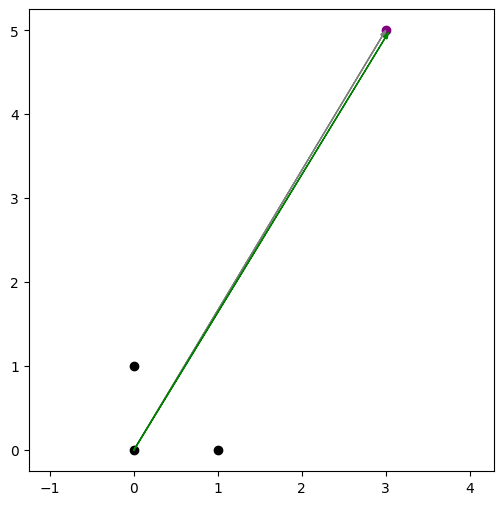

In [20]:
'''
Assumes 3 hydrophones, returns pinger location(s)
'''
def estimate_pinger_trilateration(delays, hydrophones):
    h1, h2, h3 = hydrophones
    dt_11, dt_12, dt_13 = delays
    
    dt_min = np.min(delays)
    r1_lb = c*dt_min if dt_min < 0 else 0
    r1_ub = None
    tol = 0.1
    window = 0.6 # dummy value that is greater than tol

    r1 = 10 # random initial guess
    p1 = p2 = None
    while window > tol and r1 < 1000:
        #print("r1 guess:", r1)
        #print("window:", window)
        r2 = r1 + dt_12*c
        r3 = r1 + dt_13*c
    
        try:
            p1, p2 = trilaterate(
            h1.pos_est, h2.pos_est, h3.pos_est, 
            r1, r2, r3)
            #print("p1", p1, "p2", p2)
            
            # r1 is too big
            r1_ub = r1
            r1 = r1_lb + (r1_ub-r1_lb)/2
        except:
            # r1 is too small
            r1_lb = r1
            if r1_ub is None:
                r1*=2
            else:
                r1 = r1_lb + (r1_ub-r1_lb)/2 
                
        window = 0.6 if r1_ub is None else r1_ub-r1_lb
        
    if p1 is None:
        raise Exception("does not converge")
    # pinger is chosen based on the assumption that it is at the 
    # bottom of the pool, say here the more negative z coordinate
    return p1 if p2 is None or p1[2] < p2[2] else p2

 
pinger_est = estimate_pinger_trilateration(delays, hydrophones)
      
print("pinger location:", pinger.pos)
print("pinger estimate:", pinger_est)
print("error magnitude:", np.linalg.norm(pinger.pos-pinger_est))

bearing = actual_bearing(h1, pinger)
bearing_est = pinger_est - h1.pos_est
bearing_est = bearing_est/np.linalg.norm(bearing_est)
angle_err = error_angle(bearing, bearing_est)

print("actual bearing: ", bearing)
print("estimated bearing: ", bearing_est)
print("angle error:", angle_err, "degrees")

plot_bearing(hydrophones, pinger, bearing_est)

In [21]:
'''
- errors can further be reduced by decreasing the tolerance
for r1 (or better yet finding a closed form solution for r1)

- some errors will remain due to discretization of signal, 
noise in measuring signal and inaccuracies in defining the 
hydrophone positions
'''

'\n- errors can further be reduced by decreasing the tolerance\nfor r1 (or better yet finding a closed form solution for r1)\n\n- some errors will remain due to discretization of signal, \nnoise in measuring signal and inaccuracies in defining the \nhydrophone positions\n'

pinger location: [3 5 0]
pinger estimate: [ 1.71534219  2.58169648 -0.15881924]
error magnitude: 2.7429475275542576
actual bearing:  [ 0.52827485  0.8488999  -0.01716518]
estimated bearing:  [ 0.55268155  0.83182005 -0.0511714 ]
angle error: 2.59049122 degrees


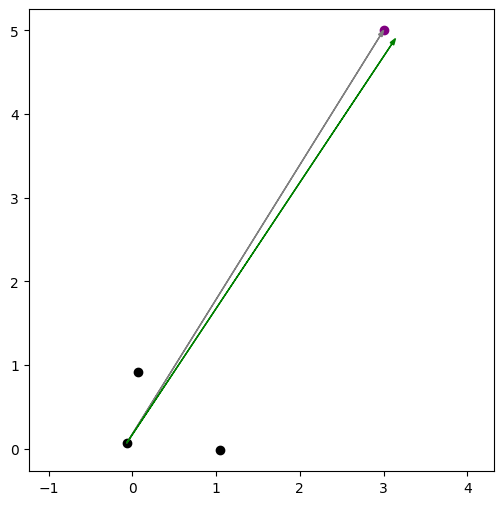

In [22]:
'''
Triliteration with imperfect hydrophones, uncertain hydrophone position
'''

pinger_est = estimate_pinger_trilateration(delays_imp, hydrophones_imp)
         
print("pinger location:", pinger.pos)
print("pinger estimate:", pinger_est)
print("error magnitude:", np.linalg.norm(pinger.pos-pinger_est))

bearing = actual_bearing(h1_imp, pinger)
bearing_est = pinger_est - h1_imp.pos_est
bearing_est = bearing_est/np.linalg.norm(bearing_est)
angle_err = error_angle(bearing, bearing_est)

print("actual bearing: ", bearing)
print("estimated bearing: ", bearing_est)
print("angle error:", angle_err, "degrees")

plot_bearing(hydrophones_imp, pinger, bearing_est)

In [23]:
'''
Plotting estimated, actual pinger locations
'''

def plot_location(hydrophones, pinger, pinger_est):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.axis('equal')
    
    plot_points(ax, hydrophones, pinger)
    ax.scatter(pinger_est[0], pinger_est[1], marker="o", color='red')
    plt.show()

pinger location: [ 0.   0.5 -5. ]
pinger estimate: [ 0.47664805  0.57464434 -0.15927241]
error magnitude: 4.8647105491132905


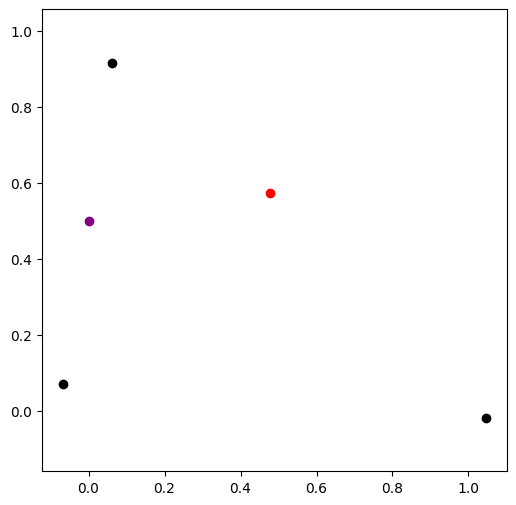

pinger location: [-1.2 -0.6 -5. ]
pinger estimate: [ 0.2948      0.4397     -0.33223767]
error magnitude: 5.01033015783133


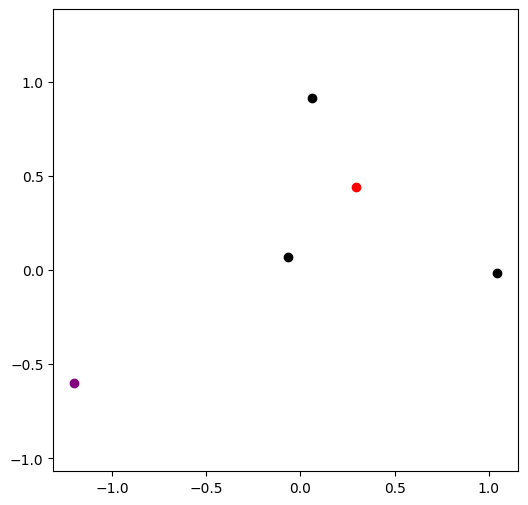

'\npinger3 = Pinger(-10, 15, 0)\nfor h in hydrophones_imp:\n    h.set_th(pinger3)\ndelays_imp = get_delays(hydrophones_imp)\npinger_est = estimate_pinger_trilateration(delays_imp, hydrophones_imp)\nplot_location(hydrophones_imp, pinger3, pinger_est)\n'

In [24]:
'''
Testing different pinger locations using trilateration, 
with imperfections
'''

# pinger directly below
pinger1 = Pinger(0, 0.5, -5)
for h in hydrophones_imp:
    h.set_th(pinger1)
delays_imp = get_delays(hydrophones_imp)
pinger_est = estimate_pinger_trilateration(delays_imp, hydrophones_imp)
print("pinger location:", pinger1.pos)
print("pinger estimate:", pinger_est)
print("error magnitude:", np.linalg.norm(pinger1.pos-pinger_est))
plot_location(hydrophones_imp, pinger1, pinger_est)


# pinger close behind
pinger2 = Pinger(-1.2, -0.6, -5)
for h in hydrophones_imp:
    h.set_th(pinger2)
delays_imp = get_delays(hydrophones_imp)
pinger_est = estimate_pinger_trilateration(delays_imp, hydrophones_imp)
print("pinger location:", pinger2.pos)
print("pinger estimate:", pinger_est)
print("error magnitude:", np.linalg.norm(pinger2.pos-pinger_est))
plot_location(hydrophones_imp, pinger2, pinger_est)

# pinger further away - this does not converge
'''
pinger3 = Pinger(-10, 15, 0)
for h in hydrophones_imp:
    h.set_th(pinger3)
delays_imp = get_delays(hydrophones_imp)
pinger_est = estimate_pinger_trilateration(delays_imp, hydrophones_imp)
plot_location(hydrophones_imp, pinger3, pinger_est)
'''

p1: [ 9.39875    16.6596875   5.84108816]
p2: [ 9.39875    16.6596875  -5.84108816]


[]

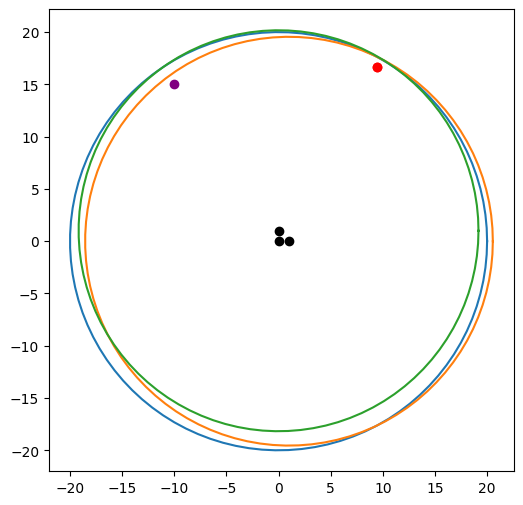

In [25]:
'''
-Trilateration method with right-angle x-y arrangement of 
hydrophones does not locate the z position of the pinger well

-The trilateration method does not seem to converge on the location
of the pinger at far distances
'''

pinger3 = Pinger(-10, 15, 0)
for h in hydrophones_imp:
    h.set_th(pinger3)
delays_imp = get_delays(hydrophones_imp)

r1 = 20
r2 = r1 + dt_12*c
r3 = r1 + dt_13*c
        
p1, p2 = trilaterate(
            h1_imp.pos_est, h2_imp.pos_est, h3_imp.pos_est, 
            r1, r2, r3)

print("p1:", p1)
print("p2:", p2)

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')

plot_points(ax, hydrophones, pinger3)
plot_circle(h1.pos[0], h1.pos[1], r1)
plot_circle(h2.pos[0], h2.pos[1], r2)
plot_circle(h3.pos[0], h3.pos[1], r3)

ax.scatter(p1[0], p1[1], marker="o", color='red')
ax.scatter(p2[0], p2[1], marker="o", color='red')

plt.plot()

In [26]:
'''
assuming we only care about the angle error in 
the X-Y plane
'''
def plane_angle_error(bearing, bearing_est):
    b = np.array(bearing)
    b[2] = 0
    b = b/np.linalg.norm(b)
    
    b_est = np.array(bearing_est)
    b_est[2] = 0
    b_est = b_est/np.linalg.norm(b_est)
    
    return error_angle(b, b_est)

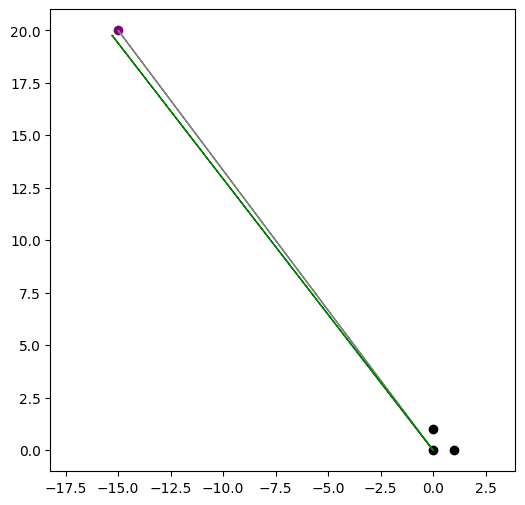

actual bearing:  [-0.6  0.8  0. ]
estimated bearing:  [-0.61187215  0.79095668 -0.        ]
XY angle error: 0.8550974 degrees


In [27]:
'''
Bearing using Planar method - (larger sampling window)
'''

# need to expand t_arr so that hydrophones witness signal
t_final = 25
dt = 0.005
n = int(t_final/dt)
t_arr = np.linspace(0, t_final, n+1)

h1 = Hydrophone(0, 0)
h2 = Hydrophone(1, 0)
h3 = Hydrophone(0, 1)
hydrophones = [h1, h2, h3]

k = 5
pinger = Pinger(-3*k, 4*k, 0)
for h in hydrophones:
    h.set_th(pinger)
delays = get_delays(hydrophones)

bearing = actual_bearing(h1, pinger)
bearing_est = estimate_bearing_planar(delays, hydrophones)
angle_err = plane_angle_error(bearing, bearing_est)

plot_bearing(hydrophones, pinger, bearing_est)

print("actual bearing: ", bearing)
print("estimated bearing: ", bearing_est)
print("XY angle error:", angle_err, "degrees")

actual bearing:  [0.6 0.8 0. ]
estimated bearing:  [ 0.59738165  0.80192659 -0.00699391]
XY angle error: 0.18625257 degrees


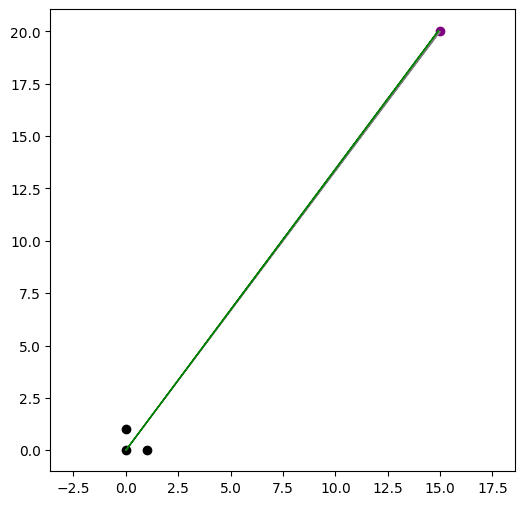

In [28]:
'''
Bearing using trilateration - (larger sampling window)
'''
pinger = Pinger(3*k, 4*k, 0*k)
for h in hydrophones:
    h.set_th(pinger)
delays = get_delays(hydrophones)
pinger_est = estimate_pinger_trilateration(delays, hydrophones)

bearing = actual_bearing(h1, pinger)
bearing_est = pinger_est - h1.pos_est
bearing_est = bearing_est/np.linalg.norm(bearing_est)
angle_err = plane_angle_error(bearing, bearing_est)

print("actual bearing: ", bearing)
print("estimated bearing: ", bearing_est)
print("XY angle error:", angle_err, "degrees")

plot_bearing(hydrophones, pinger, bearing_est)

#plot_location(hydrophones_imp, pinger3, pinger_est)

In [29]:
'''
Comparing accuracy of bearing angle found by:
1) planar method
2) trilateration method
with increasing distance to pinger (ideal hydrophones)
''' 

def get_bearing_errors(pinger, hydrophones):
    for h in hydrophones:
        h.set_th(pinger)
    delays = get_delays(hydrophones)
    
    h1 = hydrophones[0]
    bearing = actual_bearing(h1, pinger)
    
    bearing_planar = estimate_bearing_planar(delays, hydrophones)
    planar_err = plane_angle_error(bearing, bearing_planar)
    
    try:
        pinger_est = estimate_pinger_trilateration(delays, hydrophones)
        bearing_tri = pinger_est - h1.pos_est
        bearing_tri = bearing_tri/np.linalg.norm(bearing_tri)
        tri_err = plane_angle_error(bearing, bearing_tri)
    except:
        return (planar_err, None)

    return (planar_err, tri_err)



# move the pinger further away along line
planar_errors = []
tri_errors = []
distances = []

scales = [x/100 for x in range(25, 525, 25)]

px, py, pz = -3, 4, 0
for k in scales:
    pinger = Pinger(px*k, py*k, pz*k)
    planar_err, tri_err = get_bearing_errors(pinger, hydrophones)
    
    h1 = hydrophones[0]
    distances.append(np.linalg.norm(pinger.pos-h1.pos))
    planar_errors.append(planar_err)
    # keep Nones for now to correspond with distance
    tri_errors.append(tri_err) 


print("planar errors:", planar_errors)
print("tri_errors:", tri_errors)

planar errors: [20.22485943, 8.74616226, 5.69345411, 4.47787957, 3.26558792, 2.7182332, 2.05764595, 2.05764595, 2.05764595, 2.05764595, 1.38452271, 1.38452271, 0.8550974, 0.8550974, 0.8550974, 0.8550974, 0.8550974, 0.8550974, 0.8550974, 0.8550974]
tri_errors: [0.27791243, 0.03945253, 1.03364299, 3.37229089, 5.4856561, None, 7.82936331, 7.82936331, 7.82936331, 7.82936331, 13.63702566, 13.63702566, None, None, None, None, None, None, None, None]


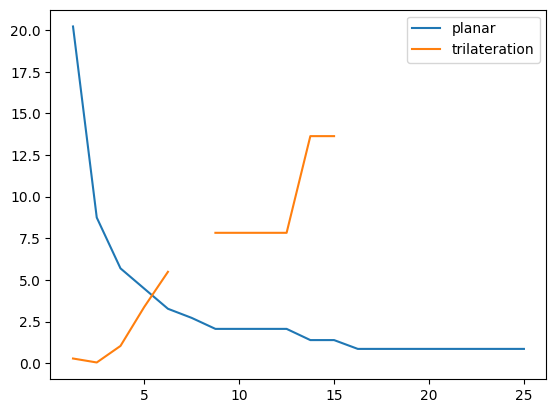

In [30]:
'''
notably, pinger locations in 1st quadrant seem to converge fine at
large distances, this is not true for pinger in 2nd quadrant

Plotting planar angle error using planar/tri method at various
distances r1
'''

plt.plot(distances, planar_errors, label="planar")
plt.plot(distances, tri_errors, label="trilateration")
plt.legend()
plt.show()

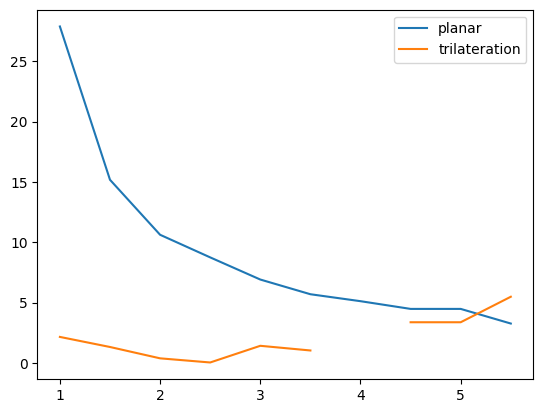

In [31]:
planar_errors = []
tri_errors = []
distances = []

scales = [x/10 for x in range(2, 12)]
px, py, pz = -3, 4, 0
for k in scales:
    pinger = Pinger(px*k, py*k, pz*k)
    planar_err, tri_err = get_bearing_errors(pinger, hydrophones)
    
    h1 = hydrophones[0]
    distances.append(np.linalg.norm(pinger.pos-h1.pos))
    planar_errors.append(planar_err)
    # keep Nones for now to correspond with distance
    tri_errors.append(tri_err)
    
plt.plot(distances, planar_errors, label="planar")
plt.plot(distances, tri_errors, label="trilateration")
plt.legend()
plt.show()

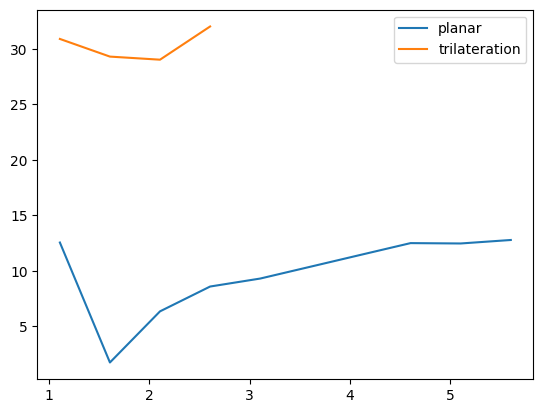

In [32]:
'''
repeating experiment with finer resolution in k=[0.1, 1.5]
using imperfect hydrophones
'''

h1_imp = ImperfectHydrophone(0, 0, 0)
h2_imp = ImperfectHydrophone(1, 0, 0)
h3_imp = ImperfectHydrophone(0, 1, 0)
hydrophones_imp = [h1_imp, h2_imp, h3_imp]

planar_errors = []
tri_errors = []
distances = []

scales = [x/10 for x in range(2, 12)]
px, py, pz = -3, 4, 0
for k in scales:
    pinger = Pinger(px*k, py*k, pz*k)
    planar_err, tri_err = get_bearing_errors(pinger, hydrophones_imp)
    
    h1 = hydrophones_imp[0]
    distances.append(np.linalg.norm(pinger.pos-h1.pos))
    planar_errors.append(planar_err)
    # keep Nones for now to correspond with distance
    tri_errors.append(tri_err)
    
plt.plot(distances, planar_errors, label="planar")
plt.plot(distances, tri_errors, label="trilateration")
plt.legend()
plt.show()

In [33]:
'''
Illustrating the 'blind spots' of trilateration method for 
hydrophone array arrangement
'''

def estimate_bearing_tri(pinger, hydrophones):
    for h in hydrophones:
        h.set_th(pinger)
    delays = get_delays(hydrophones)
    
    h1 = hydrophones[0]
    bearing = actual_bearing(h1, pinger)

    try:
        pinger_est = estimate_pinger_trilateration(delays, hydrophones)
    except:
        return None
    
    bearing_tri = pinger_est - h1.pos_est
    bearing_tri = bearing_tri/np.linalg.norm(bearing_tri)
    tri_err = np.linalg.norm(plane_angle_error(bearing, bearing_tri))
    return tri_err

    
    

t_final = 5
dt = 0.005
n = int(t_final/dt)
t_arr = np.linspace(0, t_final, n+1)
a = 10
X,Y = np.meshgrid(np.linspace(-a,a,4*a),np.linspace(-a,a,4*a))

h1 = Hydrophone(0, 0)
h2 = Hydrophone(1, 0)
h3 = Hydrophone(0, 1)
hydrophones = [h1, h2, h3]

E = np.zeros((4*a,4*a))

for y in range(-2*a, 2*a, 1):
    for x in range(-2*a, 2*a, 1):
        pinger = Pinger(x, y, 0)
        tri_err = estimate_bearing_tri(pinger, hydrophones)
        E[x+2*a][y+2*a] = tri_err
        

print("done")

/tmp/ipykernel_3286/699203067.py:10: RuntimeWarning: invalid value encountered in divide
  bearing = bearing/np.linalg.norm(bearing)


done


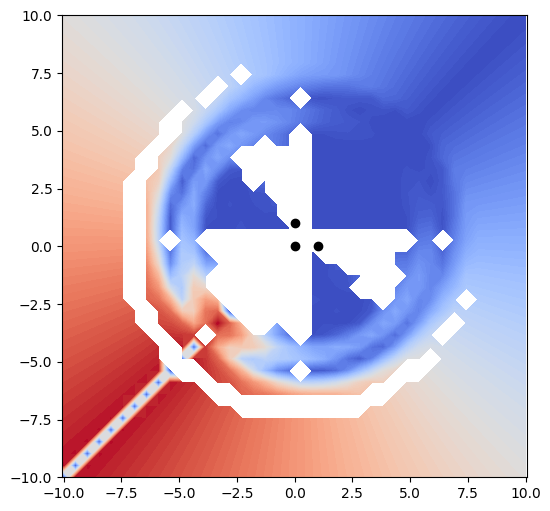

In [34]:
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')

cf = plt.contourf(X, Y, E, cmap='coolwarm', levels=100)    # first image on screen
for h in hydrophones:
        ax.scatter(h.pos[0], h.pos[1], marker="o", color='black')

fig.colorbar(cf)
fig.show()

In [35]:
'''
-This array configuration has good precision at locating a 
pinger in the 1st quadrant

-A fourth hydrophone element h4 at (1, 1, 0) could be employed 
to create 4 logical grids covering all 4 quadrants for
trilateration method to converge:
    Q1 -> (h1, h2, h3) -> h1 is ref
    Q2 -> (h2, h1, h4) -> h2 is ref
    Q1 -> (h4, h2, h3) -> h4 is ref
    Q1 -> (h3, h1, h4) -> h3 is ref
    
    
-Each 'quadrant' of arrays produces an estimate of the location 
of the pinger.Which quadrant to trust?

-A heuristic can be employed such as tracking previous estimated
location of pinger or using planar method to determine quadrant
'''

"\n-This array configuration has good precision at locating a \npinger in the 1st quadrant\n\n-A fourth hydrophone element h4 at (1, 1, 0) could be employed \nto create 4 logical grids covering all 4 quadrants for\ntrilateration method to converge:\n    Q1 -> (h1, h2, h3) -> h1 is ref\n    Q2 -> (h2, h1, h4) -> h2 is ref\n    Q1 -> (h4, h2, h3) -> h4 is ref\n    Q1 -> (h3, h1, h4) -> h3 is ref\n    \n    \n-Each 'quadrant' of arrays produces an estimate of the location \nof the pinger.Which quadrant to trust?\n\n-A heuristic can be employed such as tracking previous estimated\nlocation of pinger or using planar method to determine quadrant\n"

In [36]:
h1 = ImperfectHydrophone(0, 0)
h2 = ImperfectHydrophone(1, 0)
h3 = ImperfectHydrophone(0, 1)
hydrophones = [h1, h2, h3]

E = np.zeros((4*a,4*a))

for y in range(-2*a, 2*a, 1):
    for x in range(-2*a, 2*a, 1):
        pinger = Pinger(x, y, 0)
        tri_err = estimate_bearing_tri(pinger, hydrophones)
        E[x+2*a][y+2*a] = tri_err
        

print("done")

done


/tmp/ipykernel_3286/1043564618.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


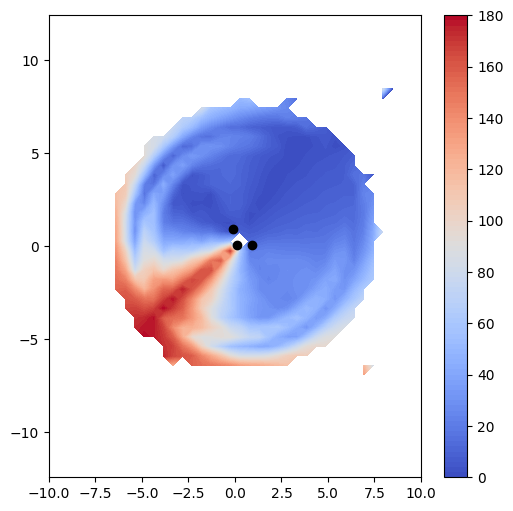

In [39]:
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')

cf = plt.contourf(X, Y, E, cmap='coolwarm', levels=100)    # first image on screen
for h in hydrophones:
        ax.scatter(h.pos[0], h.pos[1], marker="o", color='black')

fig.colorbar(cf)
fig.show()